# RNN 학습

## 사용한 데이터 1
- 캐글의 Donald Trump Rally Speeches를 사용하였다.
- 링크 : https://www.kaggle.com/christianlillelund/donald-trumps-rallies
- 도널드 트럼프가 35번의 집회에서 한 연설 전체를 포함하고 있다.
- 모두 txt 파일로 제공이 된다.
- 총 35개의 txt 파일들을 모두 사용하여 학습을 시킨다.
- 트럼프의 연설 데이터로 문장을 작성


## 사용한 데이터 2
- aiffel/lyricist/data/lyrics 에 있는 txt 파일들을 모두 사용하였다.

# 1. Trump speech Dataset

### module import

In [1]:
import glob
import fileinput
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import glob

### txt 파일들을 불러오고 데이터 크기 출력
- txt 파일들을 하나씩 열어서 마지막 문장 "."을 기준으로 split하여 raw_corpus 생성

In [2]:
# trump

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/trumpspeech/*.txt'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

print('txt파일목록\n')
for txt_file in txt_list:

    with open(txt_file, 'r') as f:
        raw = f.read()
        raw_corpus.extend(raw.split('.'))
        print(txt_file)
        
print('\n데이터크기:', len(raw_corpus))
print('\nExamples:\n', raw_corpus[:3])

txt파일목록

/aiffel/aiffel/lyricist/trumpspeech/HersheyDec10_2019.txt
/aiffel/aiffel/lyricist/trumpspeech/FayettevilleSep19_2020.txt
/aiffel/aiffel/lyricist/trumpspeech/HendersonSep13_2020.txt
/aiffel/aiffel/lyricist/trumpspeech/MinneapolisOct10_2019.txt
/aiffel/aiffel/lyricist/trumpspeech/WildwoodJan28_2020.txt
/aiffel/aiffel/lyricist/trumpspeech/MindenSep12_2020.txt
/aiffel/aiffel/lyricist/trumpspeech/ToledoJan9_2020.txt
/aiffel/aiffel/lyricist/trumpspeech/LasVegasFeb21_2020.txt
/aiffel/aiffel/lyricist/trumpspeech/TupeloNov1_2019.txt
/aiffel/aiffel/lyricist/trumpspeech/FreelandSep10_2020.txt
/aiffel/aiffel/lyricist/trumpspeech/NewMexicoSep16_2019.txt
/aiffel/aiffel/lyricist/trumpspeech/DallasOct17_2019.txt
/aiffel/aiffel/lyricist/trumpspeech/PhoenixFeb19_2020.txt
/aiffel/aiffel/lyricist/trumpspeech/BattleCreekDec19_2019.txt
/aiffel/aiffel/lyricist/trumpspeech/CincinnatiAug1_2019.txt
/aiffel/aiffel/lyricist/trumpspeech/NewHampshireFeb10_2020.txt
/aiffel/aiffel/lyricist/trumpspeech/Charlo

### raw_corpus에 대한 wordcloud plotting
- 사이즈가 큰 단어일수록 자주 나오는 단어이다.

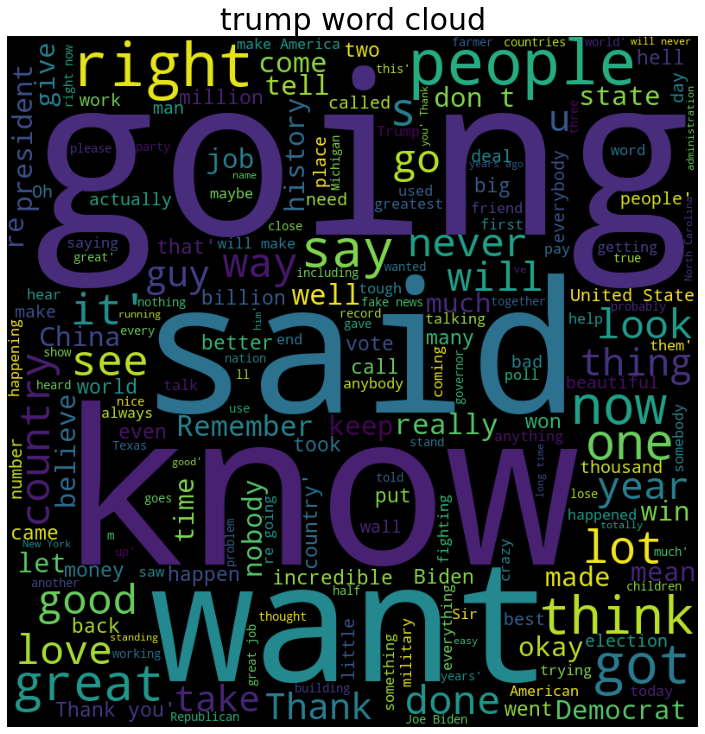

In [3]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height=800, background_color ='black', stopwords=stopwords, min_font_size=11).generate(str(raw_corpus))
plt.figure(figsize=(10,10), facecolor = None)
plt.imshow(wordcloud)
plt.rcParams.update({'font.size':25})
plt.axis("off")
plt.title('trump word cloud')
plt.tight_layout(pad=0)
plt.show()

### 필요없는 요소 제거

In [4]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence)==0:
        continue
    if sentence[-1]==":":
        continue
    if sentence[0] == '"': # 쌍따옴표 제거
        continue
        
    if idx>20:
        break
        
    print(sentence)

 Well, thank you to Vice President Pence
 Thank you, Mike
 And hello Pennsylvania
 Hello
 It's great to be back in this state that gave us the Liberty Bell, Pennsylvania Steel, Hershey chocolate
 I like Hershey chocolate
 The Nittany Lions
 The Nittany Lions, they're doing pretty well too and the incredible American Patriots just like you, you are Patriots
 Thank you very much
 Thank you
 Under Republican leadership, America is stronger than ever before and we are respected again
 Last month you saw it, we smashed expectations with another 266,000 jobs and unemployment is now more than a 50-year low
 We have never seen what's going on with different groups
 Unemployment is at a position we've never had anything like this
 You are so lucky I became your president
 I'm only kidding
 I have to say I'm kidding because the fake news back there will take that
 They'll take that statement and they'll blow it up and they'll say, "He said they were lucky to have him as president
 What a horribl

### preprocessing
### 추가한 정규표현식
- apostrophe(예 : it's, he's, they're)가 같이 제거 되어 re같은 이상한 단어를 생성하는 현상이 발생하여 ( ```\'``` )를 추가함으로써 apostrophe는 제거 되지 않도록 하게 하였다.

In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 대문자를 소문자로 바꾸고 양쪽공백 제거
    sentence = re.sub(r"([?.!,¿])", r" \1 ",sentence) # 특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z?.!,¿\']+", " ", sentence) # a-zA-Z?.!,¿ 그리고 apostrophe가 아닌 모든 문자를 하나의 공백으로.
    sentence = sentence.strip() # 양쪽 공백 제거
    sentence = '<start> ' + sentence + ' <end>' # 문장시작에 <start>, 끝에는 <end>추가
    return sentence

### corpus 리스트에 정제된 데이터 append

In [6]:
corpus = [] # 정제된 문장 넣는 빈 리스트

for sentence in raw_corpus:
    # 원치않는 문장 제거
    if len(sentence)==0: continue # 공백이 있으면 제거
    
    # 정제하고 corpus에 넣기
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
    
len(corpus[1])
print(corpus[1])

<start> thank you , mike <end>


### 토큰화
- 데이터들을 숫자로 변환해서 인공지능이 알아듣도록 해줘야한다.
- 정제된 데이터를 토큰화하여 단어사전을 만들고, 데이터를 숫자로 변환까지해준다== **벡터화**
- 숫자로 변환된 데이터 == **Tensor** 라고한다

### 추가적인 사항
- 변수 tensor에 토큰 개수 15개가 넘어가지않는 문장을 다시 할당하고
- 변수 tensor에 다시 slicing하여 15개 까지만 할당함으로써 토큰 15개까지 자르기

In [7]:
# 토큰화
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        # 12000단어를 기억할 수 있는 tokenizer
        # 이미 문장을 정제하였으니 filters가 필요없다.
        # 12000 단어에 포함되지 못한 단어는 '<unk>'로 변환
        num_words=12000,
        filters='',
        oov_token='<unk>'
    )
    # corpus를 이용하여 tokenizer 내부의 단어장 완성
    tokenizer.fit_on_texts(corpus)

    # tokenizer 이용하여 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    # 시퀀스 길이 일정하게
    # 시퀀스가 짧으면 문장 뒤에 패딩을 붙여 길이를 맞춰준다.
    # 문장 앞에 패딩을 붙여 길이를 맞추려면 padding='pre'사용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    ### 추가 : 토큰 개수 15개가 넘어가는 문장 제외 ###
    tensor = tensor[tensor[:,15]==0]
    ### 추가 : 토큰 15개까지 자르기 ###
    tensor = tensor[:,:15]

    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 116   4 ...   0   0   0]
 [  2  72   9 ...   0   0   0]
 [  2   6 882 ...   0   0   0]
 ...
 [  2 103 517 ...   0   0   0]
 [  2  72   9 ...   0   0   0]
 [  2  72   9 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fb3a7bf9e50>


In [8]:
# 토큰이 15개인 문장 shape
tensor.shape

(22905, 15)

### source input과 target input으로 나누고
### train_test_split으로 enc_train, enc_val, dec_train, dec_val 로 분배

- src_input에는 마지막 토큰을 잘라내고
- tgt_input에는 < start > 토큰을 잘라내서 RNN을 학습하기 위한 형태로 만들어준다.

In [9]:
src_input = tensor[:,:-1] # enc_train, enc_val
tgt_input = tensor[:,1:] # dec_train, dec_val

In [10]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=32)

In [11]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (18324, 14)
Target Train: (18324, 14)


In [12]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input)//BATCH_SIZE

# tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words+1


dataset=tf.data.Dataset.from_tensor_slices((enc_train, dec_train)) # tensor --> tf.data.Dataset으로 변환
dataset=dataset.shuffle(BUFFER_SIZE) # 완벽한 셔플링을 위해서는 데이터셋의 전체 크기보다 크거나 같은 Buffersize필요
dataset=dataset.batch(BATCH_SIZE,drop_remainder=True) # 256개씩 묶고 나머지 제거
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

### 모델 Subclassing

- 1개의 Embedding layer, 2개의 LSTM layer, 1개의 Dense layer
- embedding layer에서 인덱스 값을 해당 인덱스번째의 워드 벡터로 바꿔준다.

In [13]:
class TextGenerator(tf.keras.Model):
    def __init__(self,vocab_size, embedding_size,hidden_size):
        super().__init__()
        # embedding Layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)# 인덱스 값을 해당 인덱스 번째의 워드벡터로 바꿔준다. embedding_size : 단어가 추상적으로 표현되는 크기
        # 2개의 LSTM Layer
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True) # return_sequences : many to many
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True) 
        # 1개의 Dense Layer
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size=256
hidden_size=1024
model = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

In [14]:
for src_sample, tgt_sample in dataset.take(1):break # 1개의 배치를 가져온다. 256개의 문장데이터
    
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-2.92850018e-04,  6.25055909e-05, -2.92820150e-05, ...,
          1.24586746e-04,  6.15627068e-05, -1.60847470e-04],
        [-4.00015007e-04,  3.06296424e-04, -3.70499387e-04, ...,
         -8.35002211e-05, -7.06216888e-05, -3.43639113e-04],
        [-1.70025800e-04,  2.94632657e-04, -5.09065634e-04, ...,
         -2.22758987e-04,  7.74862128e-05, -5.51156758e-04],
        ...,
        [-1.66104612e-04, -4.34337649e-04,  7.47939281e-04, ...,
          1.96951837e-03,  4.12143505e-04, -1.46149556e-04],
        [-1.16676296e-04, -5.10399579e-04,  6.15475699e-04, ...,
          2.24826578e-03,  3.58377612e-04, -1.80953502e-04],
        [-1.12601861e-04, -5.84814115e-04,  5.12376311e-04, ...,
          2.53403978e-03,  2.69142707e-04, -1.80014191e-04]],

       [[-2.92850018e-04,  6.25055909e-05, -2.92820150e-05, ...,
          1.24586746e-04,  6.15627068e-05, -1.60847470e-04],
        [-4.97408968e-04,  1.92071122e-04, -2

- model의 출력 shape을 보면 (256,14,12001) 임을 알 수 있다.
- 12001은 Dense layer의 출력 차원수이다.(12001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링)
- 14는 ``` tf.keras.layers.LSTM(return_sequences=True) ``` 로 지정한 부분, LSTM은 자신에게 입력된 시퀀스 길이만큼 동일한 길이의 시퀀스를 출력

In [15]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


### 결과 1
```
embedding_size=256
hidden_size=1024
model = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)
```

일 때 val_loss 는 2.49로 2.2미만을 충족하지 못했다.

In [16]:
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, validation_data=(enc_val, dec_val), epochs=10)

Epoch 1/10
71/71 [==============================] - 29s 372ms/step - loss: 5.2587 - val_loss: 3.1546
Epoch 2/10
71/71 [==============================] - 26s 361ms/step - loss: 3.0078 - val_loss: 2.9192
Epoch 3/10
71/71 [==============================] - 26s 360ms/step - loss: 2.8258 - val_loss: 2.8220
Epoch 4/10
71/71 [==============================] - 25s 360ms/step - loss: 2.7311 - val_loss: 2.7628
Epoch 5/10
71/71 [==============================] - 26s 362ms/step - loss: 2.6517 - val_loss: 2.7050
Epoch 6/10
71/71 [==============================] - 26s 362ms/step - loss: 2.5677 - val_loss: 2.6471
Epoch 7/10
71/71 [==============================] - 26s 365ms/step - loss: 2.4968 - val_loss: 2.5892
Epoch 8/10
71/71 [==============================] - 25s 358ms/step - loss: 2.4236 - val_loss: 2.5508
Epoch 9/10
71/71 [==============================] - 26s 364ms/step - loss: 2.3589 - val_loss: 2.5202
Epoch 10/10
71/71 [==============================] - 26s 362ms/step - loss: 2.3260 - val_lo

### 결과 2
```
embedding_size=256
hidden_size=512
model2 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)
```
일 때 val_loss는 2.73 으로 오히려 더 loss값이 높아졌다.

In [17]:
embedding_size=256
hidden_size=512
model2 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

In [18]:
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model2.compile(loss=loss, optimizer=optimizer)
model2.fit(dataset, validation_data=(enc_val, dec_val), epochs=10)

Epoch 1/10
71/71 [==============================] - 15s 178ms/step - loss: 5.7000 - val_loss: 3.8263
Epoch 2/10
71/71 [==============================] - 12s 169ms/step - loss: 3.6469 - val_loss: 3.4262
Epoch 3/10
71/71 [==============================] - 12s 167ms/step - loss: 3.2219 - val_loss: 3.0682
Epoch 4/10
71/71 [==============================] - 12s 168ms/step - loss: 2.9656 - val_loss: 2.9615
Epoch 5/10
71/71 [==============================] - 12s 168ms/step - loss: 2.8725 - val_loss: 2.9022
Epoch 6/10
71/71 [==============================] - 12s 168ms/step - loss: 2.8114 - val_loss: 2.8611
Epoch 7/10
71/71 [==============================] - 12s 167ms/step - loss: 2.7508 - val_loss: 2.8245
Epoch 8/10
71/71 [==============================] - 12s 174ms/step - loss: 2.7303 - val_loss: 2.7966
Epoch 9/10
71/71 [==============================] - 12s 167ms/step - loss: 2.6844 - val_loss: 2.7661
Epoch 10/10
71/71 [==============================] - 12s 168ms/step - loss: 2.6409 - val_lo

### 결과 3
```
embedding_size=128
hidden_size=512
model3 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)
```
val_loss는 2.65로 2.2미만이 되지 못해 다시 파라미터 수정을 했다.

In [19]:
embedding_size=128
hidden_size=512
model3 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

In [20]:
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model3.compile(loss=loss, optimizer=optimizer)
model3.fit(dataset, validation_data=(enc_val, dec_val), epochs=10)

Epoch 1/10
71/71 [==============================] - 15s 171ms/step - loss: 5.7852 - val_loss: 3.8786
Epoch 2/10
71/71 [==============================] - 11s 158ms/step - loss: 3.6889 - val_loss: 3.4403
Epoch 3/10
71/71 [==============================] - 11s 160ms/step - loss: 3.1971 - val_loss: 3.0532
Epoch 4/10
71/71 [==============================] - 11s 158ms/step - loss: 2.9325 - val_loss: 2.9547
Epoch 5/10
71/71 [==============================] - 11s 160ms/step - loss: 2.8565 - val_loss: 2.8929
Epoch 6/10
71/71 [==============================] - 11s 159ms/step - loss: 2.7938 - val_loss: 2.8396
Epoch 7/10
71/71 [==============================] - 12s 175ms/step - loss: 2.7346 - val_loss: 2.7798
Epoch 8/10
71/71 [==============================] - 11s 158ms/step - loss: 2.6579 - val_loss: 2.7241
Epoch 9/10
71/71 [==============================] - 11s 160ms/step - loss: 2.6009 - val_loss: 2.6815
Epoch 10/10
71/71 [==============================] - 11s 158ms/step - loss: 2.5489 - val_lo

### 결과 4
```
embedding_size= 512
hidden_size=1024
model4 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)
```
val_loss는 2.44로 가장 낮은 val_loss를 보여줬지만 여전히 2.2아래로 내려가지 않았다.

train_loss가 처음부터 높은것으로 보아 data가 부족하여 이런 현상이 일어나는 것 같아서 더 많은 양의 데이터가 필요했다.

In [21]:
embedding_size=512
hidden_size=1024
model4 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

In [22]:
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model4.compile(loss=loss, optimizer=optimizer)
history = model4.fit(dataset, validation_data=(enc_val, dec_val), epochs=10)

Epoch 1/10
71/71 [==============================] - 33s 391ms/step - loss: 5.1289 - val_loss: 3.2953
Epoch 2/10
71/71 [==============================] - 27s 380ms/step - loss: 3.0729 - val_loss: 2.9243
Epoch 3/10
71/71 [==============================] - 27s 380ms/step - loss: 2.8256 - val_loss: 2.8176
Epoch 4/10
71/71 [==============================] - 27s 380ms/step - loss: 2.7143 - val_loss: 2.7518
Epoch 5/10
71/71 [==============================] - 27s 378ms/step - loss: 2.6056 - val_loss: 2.6706
Epoch 6/10
71/71 [==============================] - 27s 378ms/step - loss: 2.5177 - val_loss: 2.5984
Epoch 7/10
71/71 [==============================] - 27s 379ms/step - loss: 2.4521 - val_loss: 2.5492
Epoch 8/10
71/71 [==============================] - 27s 380ms/step - loss: 2.3646 - val_loss: 2.5141
Epoch 9/10
71/71 [==============================] - 27s 379ms/step - loss: 2.3114 - val_loss: 2.4753
Epoch 10/10
71/71 [==============================] - 27s 380ms/step - loss: 2.2491 - val_lo

In [24]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환한다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만든다
    #    1. 입력받은 문장의 텐서를 입력한다.
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아낸다.
    #    3. 2에서 예측된 word index를 문장 뒤에 붙인다.
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마친다.
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환한다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

### model4의 generate_text
- 아래와 같이 말이 조금 안되는 문장이긴 하지만, 문법에는 맞게 문장 생성이 되었다.

In [25]:
generate_text(model4, tokenizer, init_sentence="<start> he ")

'<start> he was a lot of the world <end> '

# 2. lyrics 데이터로 RNN학습

In [26]:
import glob
import fileinput
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import glob

데이터의 크기가 187,088로 trump 데이터(약 34,000)와는 다르게 데이터의 크기가 5~6 배 큰 것을 볼 수 있다.

In [27]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 [' There must be some kind of way outta here', 'Said the joker to the thief', "There's too much confusion"]


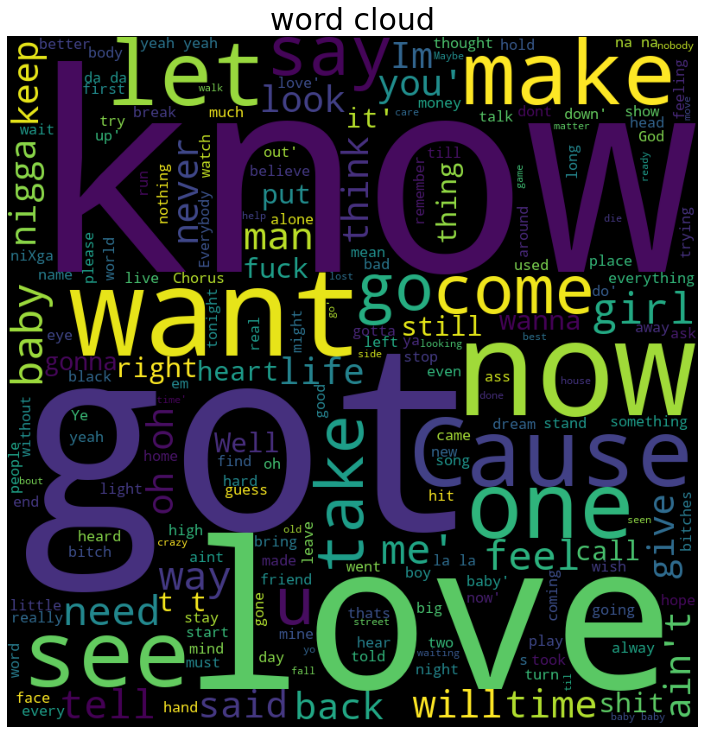

In [28]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height=800, background_color ='black', stopwords=stopwords, min_font_size=11).generate(str(raw_corpus))
plt.figure(figsize=(10,10), facecolor = None)
plt.imshow(wordcloud)
plt.rcParams.update({'font.size':25})
plt.axis("off")
plt.title('word cloud')
plt.tight_layout(pad=0)
plt.show()

In [29]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence)==0:
        continue
    if sentence[-1]==":":
        continue
    if sentence[0] == '"': # 쌍따옴표 제거
        continue
        
    if idx>20:
        break
        
    print(sentence)

 There must be some kind of way outta here
Said the joker to the thief
There's too much confusion
I can't get no relief Business men, they drink my wine
Plowman dig my earth
None were level on the mind
Nobody up at his word
Hey, hey No reason to get excited
The thief he kindly spoke
There are many here among us
Who feel that life is but a joke
But, uh, but you and I, we've been through that
And this is not our fate
So let us stop talkin' falsely now
The hour's getting late, hey All along the watchtower
Princes kept the view
While all the women came and went
Barefoot servants, too
Outside in the cold distance
A wildcat did growl
Two riders were approaching


In [30]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 대문자를 소문자로 바꾸고 양쪽공백 제거
    sentence = re.sub(r"([?.!,¿])", r" \1 ",sentence) # 특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z?.!,¿\']+", " ", sentence) # a-zA-Z?.!,¿ 그리고 apostrophe가 아닌 모든 문자를 하나의 공백으로.
    sentence = sentence.strip() # 양쪽 공백 제거
    sentence = '<start> ' + sentence + ' <end>' # 문장시작에 <start>, 끝에는 <end>추가
    return sentence

In [31]:
corpus = [] # 정제된 문장 넣는 빈 리스트

for sentence in raw_corpus:
    # 원치않는 문장 제거
    if len(sentence)==0: continue # 공백이 있으면 제거
    
    # 정제하고 corpus에 넣기
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
    
corpus[:3]

['<start> there must be some kind of way outta here <end>',
 '<start> said the joker to the thief <end>',
 "<start> there's too much confusion <end>"]

In [32]:
# 토큰화
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        # 12000단어를 기억할 수 있는 tokenizer
        # 이미 문장을 정제하였으니 filters가 필요없다.
        # 12000 단어에 포함되지 못한 단어는 '<unk>'로 변환
        num_words=12000,
        filters='',
        oov_token='<unk>'
    )
    # corpus를 이용하여 tokenizer 내부의 단어장 완성
    tokenizer.fit_on_texts(corpus)

    # tokenizer 이용하여 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    # 시퀀스 길이 일정하게
    # 시퀀스가 짧으면 문장 뒤에 패딩을 붙여 길이를 맞춰준다.
    # 문장 앞에 패딩을 붙여 길이를 맞추려면 padding='pre'사용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    ### 추가 : 토큰 개수 15개가 넘어가는 문장 제외 ###
    tensor = tensor[tensor[:,15]==0]
    ### 추가 : 토큰 15개까지 자르기 ###
    tensor = tensor[:,:15]

    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2  86 291 ...   0   0   0]
 [  2 103   5 ...   0   0   0]
 [  2 173  98 ...   0   0   0]
 ...
 [  2  69  42 ...   3   0   0]
 [  2  45   4 ...   0   0   0]
 [  2  12 720 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fb260616cd0>


In [33]:
tensor.shape

(158874, 15)

In [34]:
src_input = tensor[:,:-1] # enc_train, enc_val == X_train, X_test
tgt_input = tensor[:,1:] # dec_train, dec_val == y_train, y_test

In [35]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=32)

In [36]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (127099, 14)
Target Train: (127099, 14)


In [37]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input)//BATCH_SIZE

# tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words+1


dataset=tf.data.Dataset.from_tensor_slices((enc_train, dec_train)) # tensor --> tf.data.Dataset으로 변환
dataset=dataset.shuffle(BUFFER_SIZE) # 완벽한 셔플링을 위해서는 데이터셋의 전체 크기보다 크거나 같은 Buffersize필요
dataset=dataset.batch(BATCH_SIZE,drop_remainder=True) # 256개씩 묶고 나머지 제거
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [38]:
class TextGenerator(tf.keras.Model):
    def __init__(self,vocab_size, embedding_size,hidden_size):
        super().__init__()
        # embedding Layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)# 인덱스 값을 해당 인덱스 번째의 워드벡터로 바꿔준다. embedding_size : 단어가 추상적으로 표현되는 크기
        # 2개의 LSTM Layer
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True) # return_sequences : many to many
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True) 
        # 1개의 Dense Layer
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size=256
hidden_size=1024
model5 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

### 결과 1
```
embedding_size=256
hidden_size=1024
model5 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)
```

학습 할 데이터의 양이 많아져서 그런지 epoch의 시간이 오래 걸렸다. 하지만 train_loss는 줄은것을 볼 수 있었다.

val_loss 는 2.5로 2.2 이하로 떨어지지 않아 조건에 충족하지 못했다.

In [40]:
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model5.compile(loss=loss, optimizer=optimizer)
history = model5.fit(dataset, validation_data=(enc_val, dec_val), epochs=10)

Epoch 1/10
496/496 [==============================] - 183s 358ms/step - loss: 3.9967 - val_loss: 3.1756
Epoch 2/10
496/496 [==============================] - 179s 360ms/step - loss: 3.0971 - val_loss: 3.0038
Epoch 3/10
496/496 [==============================] - 178s 358ms/step - loss: 2.9237 - val_loss: 2.8885
Epoch 4/10
496/496 [==============================] - 178s 358ms/step - loss: 2.7817 - val_loss: 2.8027
Epoch 5/10
496/496 [==============================] - 178s 358ms/step - loss: 2.6670 - val_loss: 2.7399
Epoch 6/10
496/496 [==============================] - 178s 359ms/step - loss: 2.5656 - val_loss: 2.6871
Epoch 7/10
496/496 [==============================] - 178s 359ms/step - loss: 2.4815 - val_loss: 2.6408
Epoch 8/10
496/496 [==============================] - 178s 358ms/step - loss: 2.3923 - val_loss: 2.6020
Epoch 9/10
496/496 [==============================] - 178s 359ms/step - loss: 2.3070 - val_loss: 2.5696
Epoch 10/10
496/496 [==============================] - 178s 359m

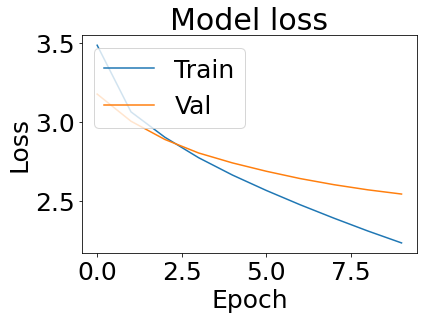

In [41]:
# model5
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### 결과 2
```
embedding_size=512
hidden_size=1024
model6 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)
```

embedding_size를 2배로 올려 진행을 해보았는데, val_loss값에 크게 변화가 없다.

val_loss는 2.49

In [42]:
embedding_size=512
hidden_size=1024
model6 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

In [43]:
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model6.compile(loss=loss, optimizer=optimizer)
history = model6.fit(dataset, validation_data=(enc_val, dec_val), epochs=10)

Epoch 1/10
496/496 [==============================] - 193s 380ms/step - loss: 3.9505 - val_loss: 3.1356
Epoch 2/10
496/496 [==============================] - 188s 378ms/step - loss: 3.0560 - val_loss: 2.9545
Epoch 3/10
496/496 [==============================] - 188s 379ms/step - loss: 2.8714 - val_loss: 2.8391
Epoch 4/10
496/496 [==============================] - 188s 378ms/step - loss: 2.7229 - val_loss: 2.7547
Epoch 5/10
496/496 [==============================] - 188s 378ms/step - loss: 2.6030 - val_loss: 2.6897
Epoch 6/10
496/496 [==============================] - 188s 378ms/step - loss: 2.5020 - val_loss: 2.6366
Epoch 7/10
496/496 [==============================] - 187s 377ms/step - loss: 2.3994 - val_loss: 2.5929
Epoch 8/10
496/496 [==============================] - 187s 377ms/step - loss: 2.3134 - val_loss: 2.5532
Epoch 9/10
496/496 [==============================] - 187s 376ms/step - loss: 2.2240 - val_loss: 2.5228
Epoch 10/10
496/496 [==============================] - 188s 378m

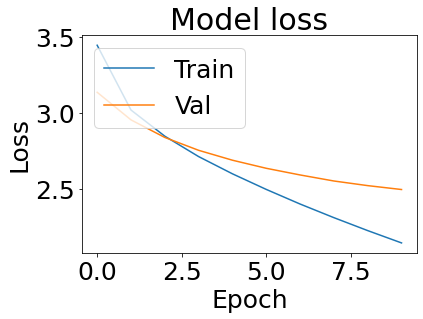

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### 결과 3
```
embedding_size=1024
hidden_size=2048
model7 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)
```

문득, 데이터의 크기가 그만큼 많아졌으니까 각 size들을 같이 크게 올려보면 loss값이 줄어들 것 같아서 위의 값들을 넣어 훈련을 시켰는데, val_loss 가 2.14(최저값) 로 줄은 것을 볼 수 있다.
다만, 8번째 epoch부터 loss값이 다시 올라가기 시작하여 그래프를 보면 과대적합인 것을 볼 수 있다.

In [45]:
embedding_size=1024
hidden_size=2048
model7 = TextGenerator(tokenizer.num_words+1, embedding_size, hidden_size)

In [46]:
optimizer = tf.keras.optimizers.Adam() 
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model7.compile(loss=loss, optimizer=optimizer)
history = model7.fit(dataset, validation_data=(enc_val, dec_val), epochs=10)

Epoch 1/10
496/496 [==============================] - 564s 1s/step - loss: 3.7356 - val_loss: 2.8865
Epoch 2/10
496/496 [==============================] - 542s 1s/step - loss: 2.7495 - val_loss: 2.6101
Epoch 3/10
496/496 [==============================] - 544s 1s/step - loss: 2.3643 - val_loss: 2.4262
Epoch 4/10
496/496 [==============================] - 543s 1s/step - loss: 2.0051 - val_loss: 2.2915
Epoch 5/10
496/496 [==============================] - 542s 1s/step - loss: 1.6762 - val_loss: 2.1992
Epoch 6/10
496/496 [==============================] - 544s 1s/step - loss: 1.4074 - val_loss: 2.1546
Epoch 7/10
496/496 [==============================] - 542s 1s/step - loss: 1.2089 - val_loss: 2.1449
Epoch 8/10
496/496 [==============================] - 541s 1s/step - loss: 1.0790 - val_loss: 2.1593
Epoch 9/10
496/496 [==============================] - 543s 1s/step - loss: 1.0075 - val_loss: 2.1769
Epoch 10/10
496/496 [==============================] - 542s 1s/step - loss: 0.9704 - val_lo

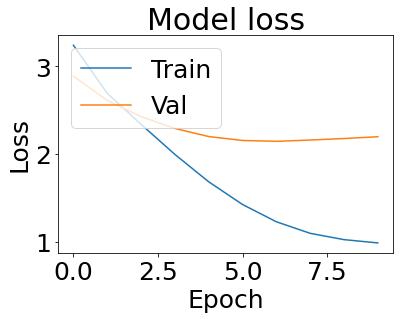

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [49]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환한다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만든다
    #    1. 입력받은 문장의 텐서를 입력한다.
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아낸다.
    #    3. 2에서 예측된 word index를 문장 뒤에 붙인다.
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마친다.
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환한다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

### model7 로 generate_text
- 문장의 완성도가 올라간 것 처럼 보인다.

In [52]:
generate_text(model7, tokenizer, init_sentence="<start> we ")

'<start> we can make it easy if we lift each other <end> '

In [53]:
generate_text(model7, tokenizer, init_sentence="<start> he ")

'<start> he got toe jam football <end> '

In [54]:
generate_text(model7, tokenizer, init_sentence="<start> come ") # 랩퍼들의 가사 영향을 받아서 그런지 비속어도 섞인다.

'<start> come on motherfuckers come on <end> '

In [55]:
generate_text(model7, tokenizer, init_sentence="<start> could ")

'<start> could i make u breakfast sometime <end> '

In [56]:
generate_text(model7, tokenizer, init_sentence="<start> may ")

'<start> may your skies be blue <end> '

In [58]:
generate_text(model7, tokenizer, init_sentence="<start> dance ")

'<start> dance me to the end of love <end> '

### 고찰
1. 데이터가 적으면 embedding과 hidden size의 수정으로는 loss값을 줄이는 것이 어렵다는것을 알게되었고

2. 데이터의 양에 따라 embedding, hidden size의 크기도 늘려주면 loss값이 줄어든다는 것을 알게되었다.

3. 데이터의 양이 많으면 학습을 하는데에 많은 시간이 걸리며, mini batch사이즈라던가, 네트워크layer 를 몇 층 더 쌓아야 할 것 같고, 학습한 모델을 따로 저장할 수 있는 방법을 통하여 시간을 단축시켜야 할 필요성을 느낀다.

4. BATCH_SIZE와 optimizer, hidden_size, embedding_size값들을 같이 수정하여 모델의 성능을 높일 수 있을것같다.

5. model7의 과대적합 문제를 해결 할 방법을 따로 생각을 해봐야겠다.

### 직면한 문제점 및 해결

1. Trump 데이터에서 줄이 나눠져 있지않아 txt파일 자체가 하나의 인덱스로 되었는데, split(".")을 하여 마침표를 기준으로 인덱스를 나누었다. 
2. 또한 append를 했을 때에는 2차원 array가 되어서 extend로 1차원 array로 맞추었다.
3. apostrophe를 남기려고 \'를 추가하였다.
4. wordcloud에서 str에러가 자꾸 났는데, 마지막 generate에 str을 붙여줌으로써 해결이 되었다.